In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import seaborn as sns
import random
from functions_and_objects import prep_all_df_for_classification

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve,precision_recall_fscore_support)

import joblib


from functions_and_objects import (impute_means_zeros_maxs_X,parse_percentage,
                                   clean_LC_data_classification_eval,preprocessing_eval, 
                                   columns_list, nan_max_cols, nan_mean_cols, nan_zero_cols, dtype,
                                   one_hot_encode_eval, concat_X_and_6ohe_dfs,
                                   prep_all_df_for_classification,
                                   classification_model_eval_prep_pipeline,
                                   current_pipeline)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, #classification
                             f1_score, roc_auc_score, roc_curve,precision_recall_fscore_support, #classification
                             r2_score,mean_squared_error) #regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Using Entire Dataset (memory issues possible)

In [2]:
raw_q42017 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2017Q4.csv',header=1)
raw_q32017 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2017Q3.csv',header=1)
raw_q22017 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2017Q2.csv',header=1)
raw_q12017 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2017Q1.csv',header=1)
raw_q42016 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2016Q4.csv',header=1)
raw_q32016 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2016Q3.csv',header=1)
raw_q22016 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2016Q2.csv',header=1)
raw_q12016 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2016Q1.csv',header=1)
raw_2015 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2015.csv',header=1)
raw_2014 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2014.csv',header=1)
raw_2012to2013 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2012to2013.csv',header=1)
raw_2007to2011 = pd.read_csv('~/peervest/lc_data/LoanStats_securev1_2007to2011.csv',header=1)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,118) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/

In [3]:
dfs_list = [raw_q42017,raw_q32017,raw_q22017,raw_q12017,
           raw_q42016,raw_q32016,raw_q22016,raw_q12016,raw_2015,
           raw_2014,raw_2012to2013, raw_2007to2011]

In [4]:
(X_train_classif, X_test_classif, y_train_classif, y_test_classif) = classification_model_eval_prep_pipeline(dfs_list)

/home/jupyter/peervest/functions_and_objects.py:243: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  raw_lc_df['earliest_cr_line'] = pd.to_timedelta(pd.to_datetime(raw_lc_df['earliest_cr_line'])).dt.days
/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/jupyter/peervest/functions_and_objects.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X_train[col] = X_train[col].fillna(0.0)
/home/jupyter/peervest/functions_and_objects.py:197: Setti

In [7]:
print(X_train_classif.shape)
print(y_train_classif.shape)
print(X_test_classif.shape)
print(y_test_classif.shape)

(880950, 1133)
(377551, 1133)
(880950, 1)
(377551, 1)


## Classification Modeling (Fully Paid = 1, Charged-Off = 0)

#### Standard Scaling

In [5]:
ss = StandardScaler()
X_train_classif_s = ss.fit_transform(X_train_classif)
X_test_classif_s = ss.transform(X_test_classif)

In [6]:
X_train_classif_s = X_train_classif_s.astype('float32')

In [7]:
X_test_classif_s = X_test_classif_s.astype('float32')

#### Logistic Regression v1

In [9]:
y_train_classif['loan_status'] = y_train_classif['loan_status'].astype(int)
y_test_classif['loan_status'] = y_test_classif['loan_status'].astype(int)

In [10]:
log_reg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_classif_s,y_train_classif)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
y_test_classif_preds = log_reg.predict(X_test_classif)

In [12]:
y_test_classif_preds_proba = log_reg.predict_proba(X_test_classif)
y_test_classif_preds_proba

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [14]:
log_reg.classes_

array([0, 1])

(array([5.24790e+04, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.25071e+05]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

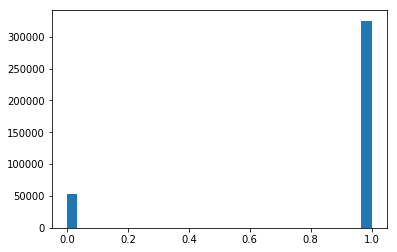

In [16]:
plt.hist(y_test_classif_preds_proba[:,1],bins=30,range=(0,1))

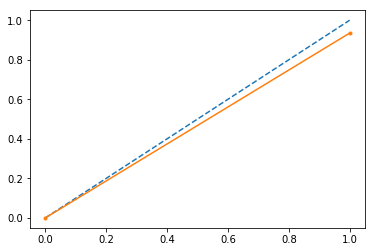

In [19]:
# predict probabilities
probs = y_test_classif_preds_proba[:,1]
# reliability diagram
fop, mpv = calibration_curve(y_test_classif, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

In [24]:
print ("Precision Fully Paid: {}".format(precision_score(y_test_all,y_test_all_preds)))
print ("Recall Fully Paid: {}".format(recall_score(y_test_all,y_test_all_preds)))
print ("F-1 Score Fully Paid: {}".format(f1_score(y_test_all,y_test_all_preds)))
print ("ROC-AUC Score: {}".format(roc_auc_score(y_test_all,y_test_all_preds)))

Precision Fully Paid: 0.9996676669562242
Recall Fully Paid: 0.9994637699276911
F-1 Score Fully Paid: 0.9995657080439424
ROC-AUC Score: 0.9990455291733132


In [25]:
#precision, recall, f1-score
print ("Precision, Recall, F, & Support By Class [0,1] aka [Default,Fully Paid]: {}".format(
    precision_recall_fscore_support(y_test_all,y_test_all_preds)))

print ("Precision, Recall, F, & Support Weighted Average by Support: {}".format(
    precision_recall_fscore_support(y_test_all,y_test_all_preds,average='weighted')))

Precision, Recall, F, & Support By Class [0,1] aka [Default,Fully Paid]: (array([0.9977865 , 0.99966767]), array([0.99862729, 0.99946377]), array([0.99820672, 0.99956571]), array([ 73577, 303974]))
Precision, Recall, F, & Support Weighted Average by Support: (0.9993010656372601, 0.9993007567189598, 0.9993008683031771, None)


### Utilize JobLib to save

In [13]:
# save the model to disk
filename = 'log_reg_v2.joblib'
joblib.dump(log_reg, filename)

['log_reg_v2.joblib']

### Quick test of JobLib loading of fitted model

In [32]:
# test load the model from disk
loaded_log_reg_v1 = joblib.load(filename)
result = loaded_log_reg_v1.predict(X_test_all)

In [33]:
print ("Precision Fully Paid: {}".format(precision_score(y_test_all,result)))
print ("Recall Fully Paid: {}".format(recall_score(y_test_all,result)))
print ("F-1 Score Fully Paid: {}".format(f1_score(y_test_all,result)))
print ("ROC-AUC Score: {}".format(roc_auc_score(y_test_all,result)))

Precision Fully Paid: 0.9996676669562242
Recall Fully Paid: 0.9994637699276911
F-1 Score Fully Paid: 0.9995657080439424
ROC-AUC Score: 0.9990455291733132


## Use Model #1: Classification Model to Filter Rows for Model #2: Regression on IRR
- I will use my predicted classification from Model #1 on train set to feed to Model #2, rather than filtering using pre-labelled classes
- This is what I would need to do with new, real-world data so my training process should mimic this
